https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

### Dealing with missing values
First we have to see how many missing values are (which were coded as “?” for most variables in the data):

In [2]:
df = pd.read_csv('diabetic_data.csv')
df = df.replace(['?', 'Unknown/Invalid'], [np.nan,np.nan])

In [3]:
#Total Missing vales and percentage respective percentage per column
missing = df.isnull().sum()
percent_missing = round((df.isnull().sum() * 100 / len(df)),3)
missing_df = pd.DataFrame({'missing': missing,'percent_missing': percent_missing })
missing_df[(missing_df['missing'] > 0) & (missing_df['percent_missing']>0)]

,missing,percent_missing
race,2273,2.234
gender,3,0.003
weight,98569,96.858
payer_code,40256,39.557
medical_specialty,49949,49.082
diag_1,21,0.021
diag_2,358,0.352
diag_3,1423,1.398


#### Preprocessing

1. Weight and payer code is missing in over 98% and 40% records. Owing to the poor interpretability of missing values and little predictive generalizability to other patients, best thing is to just drop it. We also noticed that for two variables (drugs named citoglipton and examide), all records have the same value. So essentially these cannot provide any interpretive or discriminatory information for predicting readmission, and we dropped these columns as well. 
2. We found that 3 values from gender is having 'Invalid/Unknown', so we only drop those records.
3. Primary (diag_1), Secondary (diag_2) and Additional (diag_3) diagnoses were have very few missing values. Technically, if all three are missing, that’s bad data. So we only drop those records where all three diagnoses are missing.
4. since we are trying to predict readmissions, those patients who died during this hospital admission, have zero probability of readmission. So we should remove those records (discharge_disposition = 11).

In [4]:
#1. Dropping ['weight',,'citoglipton','examide', payer_code ]
df = df.drop(['weight','citoglipton' ,'examide', 'payer_code'], axis = 1)

#2. Dropping 3 null valued rows from gender (where 'Invalid/Unknown')
df = df[~(df['gender'].isnull())]

#3. Taking only that rows which donot contained diag_1, diag_2,diag_3 all null(i.e. 1 row in total dropped)
df1 = df[~(df['encounter_id']== 277875756)]

#4. Dropping records where discharge_disposition_id is 11
df1 = df1[~(df1['discharge_disposition_id'] == 11)]

Dealing with age:

The dataset only gives us age as 10 year categories, so we don’t know the exact age of each patient. The previous study on this dataset used age categories as nominal variables, but we wanted to be able to see the effect of increasing age on readmission, even if in a crude way. To do that, we assume that age of the patient on average lies at the midpoint of the age category. For example, if the patient’s age category is 20–30 years, then we assume the age = 25 years. So we converted age categories to midpoints, resulting in a numeric variable:

In [5]:
#changed age bins to their median
l = [5,15,25,35,45,55,65,75,85,95]

for i in range(len(df1.age.unique())):
    df1.age.replace(df1.age.unique()[i],l[i], inplace = True)

### Creating and/or Recoding New Features

Service utilization: 

The data contains variables for number of inpatient (admissions), emergency room visits and outpatient visits for a given patient in the previous one year. These are (crude) measures of how much hospital/clinic services a person has used in the past year. We added these three to create a new variable called service utilization (see figure below). The idea was to see which version gives us better results. Granted, we did not apply any special weighting to the three ingredients of service utilization but we wanted to try something simple at this stage.

In [6]:
df1['service_utilization'] = df1['number_outpatient'] + df1['number_emergency'] + df1['number_inpatient']
df1 = df1.drop(['number_outpatient','number_emergency','number_inpatient'], axis =1)

Admission_type_id:

1, 2 and 7 correspond to Emergency, Urgent Care and Trauma, and thus were combined into a single category as these are all non-elective situations.

In [7]:
df1['admission_type_id'] = df1['admission_type_id'].replace(2,1)
df1['admission_type_id'] = df1['admission_type_id'].replace(7,1)
df1['admission_type_id'] = df1['admission_type_id'].replace(6,5)
df1['admission_type_id'] = df1['admission_type_id'].replace(8,5)

Label Encoding some variables

In [8]:

keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for col in keys:
    df1[col] = df1[col].apply(lambda x: 0 if x == 'No' else 1 if x == 'Steady' else 2 if x == 'Down' else 3)

df1.change = df1.change.apply(lambda x: 0 if x=='No' else 1)
df1.diabetesMed = df1.diabetesMed.apply(lambda x: 0 if x=='No' else 1)
    


Recoding the outcome variable: 

The outcome we are looking at is whether the patient gets readmitted to the hospital within 30 days or not. The variable actually has < 30, > 30 and No Readmission categories. To reduce our problem to a binary classification, we combined the readmission after 30 days and no readmission into a single category:

In [9]:
df1.readmitted = df1.readmitted.apply(lambda x: 1 if x=='<30' else 0)

Categorization of diagnoses:

The dataset contained upto three diagnoses for a given patient (primary, secondary and additional). However, each of these had 700–900 unique ICD codes and it is extremely difficult to include them in the model and interpret meaningfully. Therefore, we collapsed these diagnosis codes into 9 disease categories in an almost similar fashion to that done in the original publication using this dataset. These 9 categories include Circulatory, Respiratory, Digestive, Diabetes, Injury, Musculoskeletal, Genitourinary, Neoplasms, and Others.

#Circulatory 390–459, 785 
#Respiratory 460–519, 786 
#Digestive 520–579, 787 
#Diabetes 250.xx 
#Injury 800–999 
#Musculoskeletal 710–739 
#Genitourinary 580–629, 788 
#Neoplasms 140–239 ,780, 781, 784, 790–799,240–279,680–709, 782
#Others---: 001–139 ,290–319 ,E–V 918 ,280–289 ,320–359,630–679 ,360–389 ,740–759

Treating Diagnosis 1:

In [10]:
#Replacing E and V values in dataset first
listi=df1[df1['diag_1'].str.startswith("V",na=False)].index
df1.loc[listi,'diag_1'] = "9999"
listii=df1[df1['diag_1'].str.startswith("E",na=False)].index
df1.loc[listii,'diag_1'] = "9999"
df1.diag_1 = df1.diag_1.fillna(-1)
df1['diag_1'] = df1['diag_1'].astype('float64')

Circulatory_index = []
Respiratory_index = []
Digestive_index = []
Diabetes_index = []
Injury_index = []
Musculoskeletal_index = []
Genitourinary_index = []
Neoplasms_values = []
Neoplasms_index = []
Other_values = []
Other_index = []

Circulatory_index = df1[(df1['diag_1']>=390) & (df1['diag_1']<=459)].index

Circulatory_index.append(df1[df1['diag_1']==785].index)

Respiratory_index = df1[(df1['diag_1']>=460) & (df1['diag_1']<=519)].index

Digestive_index = df1[(df1['diag_1']>=520) & (df1['diag_1']<=579)].index

Diabetes_index = df1[(df1['diag_1']>=250.00) & (df1['diag_1']<251)].index
Injury_index = df1[(df1['diag_1']>=800) & (df1['diag_1']<=999.00)].index
Musculoskeletal_index = df1[(df1['diag_1']>=710) & (df1['diag_1']<=739)].index

Genitourinary_index = df1[(df1['diag_1']>=580) & (df1['diag_1']<=629)].index

for i in df1['diag_1']:
    if ((i>=1) & (i<250)) or ((i>250) & (i<=279)) or ((i>=680) & (i<=709)) or ((i>=790) & (i<=799)) or ((i>=780) & (i<=784)) or (i==789):
        Neoplasms_values.append(i)
Neoplasms_index = df1[df1['diag_1'].isin(Neoplasms_values)].index

for j in df1['diag_1']:
    if ((j>=280) & (j<=389)) or ((j>=630) & (j<=679)) or ((j>=740) & (j<=759)) or (j==9999):
        Other_values.append(j)
Other_index = df1[df1['diag_1'].isin(Other_values)].index

df1['diag_1'] = df1['diag_1'].replace([785.0,786.0,787.0,788.0],['Circulatory','Respiratory','Digestive','Genitourinary'])


df1.loc[Circulatory_index,'diag_1'] = 'Circulatory'
df1.loc[Respiratory_index,'diag_1'] = 'Respiratory'
df1.loc[Digestive_index,'diag_1'] = 'Digestive'
df1.loc[Diabetes_index,'diag_1'] = 'Diabetes'
df1.loc[Injury_index,'diag_1'] = 'Injury'
df1.loc[Musculoskeletal_index,'diag_1'] = 'Musculoskeletal'
df1.loc[Genitourinary_index,'diag_1'] = 'Genitourinary'
df1.loc[Neoplasms_index,'diag_1'] = 'Neoplasms'
df1.loc[Other_index,'diag_1'] = 'Other'


Treating Diagnosis 2:

In [11]:
#Replacing E and V values in dataset first
listi=df1[df1['diag_2'].str.startswith("V",na=False)].index
df1.loc[listi,'diag_2'] = "9999"
listii=df1[df1['diag_2'].str.startswith("E",na=False)].index
df1.loc[listii,'diag_2'] = "9999"
df1.diag_2 = df1.diag_2.fillna(-1)
df1['diag_2'] = df1['diag_2'].astype('float64')

Circulatory_index = []
Respiratory_index = []
Digestive_index = []
Diabetes_index = []
Injury_index = []
Musculoskeletal_index = []
Genitourinary_index = []
Neoplasms_values = []
Neoplasms_index = []
Other_values = []
Other_index = []

Circulatory_index = df1[(df1['diag_2']>=390) & (df1['diag_2']<=459)].index

Circulatory_index.append(df1[df1['diag_2']==785].index)

Respiratory_index = df1[(df1['diag_2']>=460) & (df1['diag_2']<=519)].index

Digestive_index = df1[(df1['diag_2']>=520) & (df1['diag_2']<=579)].index

Diabetes_index = df1[(df1['diag_2']>=250.00) & (df1['diag_2']<251)].index
Injury_index = df1[(df1['diag_2']>=800) & (df1['diag_2']<=999.00)].index
Musculoskeletal_index = df1[(df1['diag_2']>=710) & (df1['diag_2']<=739)].index

Genitourinary_index = df1[(df1['diag_2']>=580) & (df1['diag_2']<=629)].index

for i in df1['diag_2']:
    if ((i>=1) & (i<250)) or ((i>250) & (i<=279)) or ((i>=680) & (i<=709)) or ((i>=790) & (i<=799)) or ((i>=780) & (i<=784)) or (i==789):
        Neoplasms_values.append(i)
Neoplasms_index = df1[df1['diag_2'].isin(Neoplasms_values)].index

for j in df1['diag_2']:
    if ((j>=280) & (j<=389)) or ((j>=630) & (j<=679)) or ((j>=740) & (j<=759)) or (j==9999):
        Other_values.append(j)
Other_index = df1[df1['diag_2'].isin(Other_values)].index

df1['diag_2'] = df1['diag_2'].replace([785.0,786.0,787.0,788.0],['Circulatory','Respiratory','Digestive','Genitourinary'])


df1.loc[Circulatory_index,'diag_2'] = 'Circulatory'
df1.loc[Respiratory_index,'diag_2'] = 'Respiratory'
df1.loc[Digestive_index,'diag_2'] = 'Digestive'
df1.loc[Diabetes_index,'diag_2'] = 'Diabetes'
df1.loc[Injury_index,'diag_2'] = 'Injury'
df1.loc[Musculoskeletal_index,'diag_2'] = 'Musculoskeletal'
df1.loc[Genitourinary_index,'diag_2'] = 'Genitourinary'
df1.loc[Neoplasms_index,'diag_2'] = 'Neoplasms'
df1.loc[Other_index,'diag_2'] = 'Other'

Treating Diagnosis 3:

In [12]:
#Replacing E and V values in dataset first
listi=df1[df1['diag_3'].str.startswith("V",na=False)].index
df1.loc[listi,'diag_3'] = "9999"
listii=df1[df1['diag_3'].str.startswith("E",na=False)].index
df1.loc[listii,'diag_3'] = "9999"
df1.diag_3 = df1.diag_3.fillna(-1)
df1['diag_3'] = df1['diag_3'].astype('float64')

Circulatory_index = []
Respiratory_index = []
Digestive_index = []
Diabetes_index = []
Injury_index = []
Musculoskeletal_index = []
Genitourinary_index = []
Neoplasms_values = []
Neoplasms_index = []
Other_values = []
Other_index = []

Circulatory_index = df1[(df1['diag_3']>=390) & (df1['diag_3']<=459)].index

Circulatory_index.append(df1[df1['diag_3']==785].index)

Respiratory_index = df1[(df1['diag_3']>=460) & (df1['diag_3']<=519)].index

Digestive_index = df1[(df1['diag_3']>=520) & (df1['diag_3']<=579)].index

Diabetes_index = df1[(df1['diag_3']>=250.00) & (df1['diag_3']<251)].index
Injury_index = df1[(df1['diag_3']>=800) & (df1['diag_3']<=999.00)].index
Musculoskeletal_index = df1[(df1['diag_3']>=710) & (df1['diag_3']<=739)].index

Genitourinary_index = df1[(df1['diag_3']>=580) & (df1['diag_3']<=629)].index

for i in df1['diag_3']:
    if ((i>=1) & (i<250)) or ((i>250) & (i<=279)) or ((i>=680) & (i<=709)) or ((i>=790) & (i<=799)) or ((i>=780) & (i<=784)) or (i==789):
        Neoplasms_values.append(i)
Neoplasms_index = df1[df1['diag_3'].isin(Neoplasms_values)].index

for j in df1['diag_3']:
    if ((j>=280) & (j<=389)) or ((j>=630) & (j<=679)) or ((j>=740) & (j<=759)) or (j==9999):
        Other_values.append(j)
Other_index = df1[df1['diag_3'].isin(Other_values)].index

df1['diag_3'] = df1['diag_3'].replace([785.0,786.0,787.0,788.0],['Circulatory','Respiratory','Digestive','Genitourinary'])


df1.loc[Circulatory_index,'diag_3'] = 'Circulatory'
df1.loc[Respiratory_index,'diag_3'] = 'Respiratory'
df1.loc[Digestive_index,'diag_3'] = 'Digestive'
df1.loc[Diabetes_index,'diag_3'] = 'Diabetes'
df1.loc[Injury_index,'diag_3'] = 'Injury'
df1.loc[Musculoskeletal_index,'diag_3'] = 'Musculoskeletal'
df1.loc[Genitourinary_index,'diag_3'] = 'Genitourinary'
df1.loc[Neoplasms_index,'diag_3'] = 'Neoplasms'
df1.loc[Other_index,'diag_3'] = 'Other'

Dealing with Medical Speciality:

Analyzing Medical_specialty column:
After initial observation, it is clear that this column has a lot of missing values but instead of dropping the column, we decided to keep this column since this might help us in determining which department is contributing towards readmissions and corrective measures can be taken.
There were multiple specialties with similar department types like, pediatrics, surgery and cardiology so they were grouped into their respective departments as one specialty.
Later we calculated the % contribution of each specialty and those with less than 3% contribution were grouped together as ‘Grouped’ for better classification within this column.

In [13]:
## filling missing values with 'Missing'
df1['medical_specialty'].fillna('Missing', inplace=True)
## grouping all medical_specialities with surgery involved
surg=df1[df1['medical_specialty'].str.startswith("Surg",na=False)].index
df1.loc[surg,'medical_specialty'] = "Surgery"
## grouping all medical_specialities that are cardio related
card=df1[df1['medical_specialty'].str.startswith("Cardiolo",na=False)].index
df1.loc[card,'medical_specialty'] = "Cardiology"
## grouping all medical_specialities that are Pediatrics related
ped=df1[df1['medical_specialty'].str.startswith("Pedia",na=False)].index
df1.loc[ped,'medical_specialty'] = "Pediatrics"

In [14]:
## Checking for each speciality %
med_speciality=df1['medical_specialty'].unique()
count=0
a=[]
p=[]
for i in med_speciality:
    for j in df1['medical_specialty']:
        if j == i:
            count=count+1
    a.append(count)
    p.append(round((count/len(df1['medical_specialty'])*100),2))
    # print(i, count, round((count/len(df1['medical_specialty'])*100),2))
    count=0
data=pd.DataFrame({'med_speciality': med_speciality, 'Count':a, '%':p})
data.sort_values('%', ascending=False)

,med_speciality,Count,%
1,Missing,49128,49.07
2,InternalMedicine,14327,14.31
11,Emergency/Trauma,7457,7.45
3,Family/GeneralPractice,7302,7.29
4,Cardiology,5302,5.30
5,Surgery,5054,5.05
8,Nephrology,1544,1.54
6,Orthopedics,1394,1.39
9,Orthopedics-Reconstructive,1231,1.23
40,Radiologist,1130,1.13


In [15]:
## grouping all the departments under 3%
df1['medical_specialty'] = df1['medical_specialty'].apply(lambda x: 'Grouped' if x not in ['Missing', 'InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice', 'Cardiology', 'Surgery'] else x)

In [16]:
df1['race'] = df1['race'].fillna('Missing_race')
df1['diag_1'] = df1['diag_1'].replace(-1,'Missing_diag1')
df1['diag_2'] = df1['diag_2'].replace(-1,'Missing_diag2')
df1['diag_3'] = df1['diag_3'].replace(-1,'Missing_diag3')

In [17]:
#We also reduced both A1C test result and Glucose serum test result into categories of Normal, None and Missing.
    
#df1.max_glu_serum = df1.max_glu_serum.apply(lambda x: -1 if x=='None' else 0 if x=='Norm' else 1)
#df1.A1Cresult = df1.A1Cresult.apply(lambda x: -1 if x=='None' else 0 if x=='Norm' else 1)
df1.max_glu_serum = df1.max_glu_serum.replace('None', 'Missing_max_glu_serum')
df1.A1Cresult = df1.A1Cresult.replace('None','Missing_A1Cresult' )
df1.max_glu_serum = df1.max_glu_serum.replace(['>300','>200'],'Not_Normal')
df1.A1Cresult = df1.A1Cresult.replace(['>7','>8'],'Not_Normal')

In [18]:
# Finding unique values in all the columns
for i in df1.columns:
    print(i , ' : ')
    print(len(df1[i].unique()))
    print(df1[i].unique())
    print('\n\n')

encounter_id  : 
100120
[  2278392    149190     64410 ... 443854148 443857166 443867222]



patient_nbr  : 
70442
[  8222157  55629189  86047875 ... 140199494 120975314 175429310]



race  : 
6
['Caucasian' 'AfricanAmerican' 'Missing_race' 'Other' 'Asian' 'Hispanic']



gender  : 
2
['Female' 'Male']



age  : 
10
[ 5 15 25 35 45 55 65 75 85 95]



admission_type_id  : 
4
[5 1 3 4]



discharge_disposition_id  : 
25
[25  1  3  6  2  5  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28 19
 27]



admission_source_id  : 
17
[ 1  7  2  4  5 20  6  3 17  8  9 14 10 22 11 25 13]



time_in_hospital  : 
14
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]



medical_specialty  : 
7
['Grouped' 'Missing' 'InternalMedicine' 'Family/GeneralPractice'
 'Cardiology' 'Surgery' 'Emergency/Trauma']



num_lab_procedures  : 
118
[ 41  59  11  44  51  31  70  73  68  33  47  62  60  55  49  75  45  29
  35  42  66  36  19  64  25  53  52  87  27  37  28  48  10   2  65  67
  40  54  58  57  43  32  83  34  3

In [19]:
df2 = df1.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df2.shape

(70442, 44)

### Seperating Dependent and Independent Variable/Features

In [20]:
df2 = df2.drop(['encounter_id','patient_nbr'], axis = 1)

In [50]:
df2_dummies = pd.get_dummies(df2, drop_first= True)

In [51]:
X = df2_dummies.drop('readmitted', axis = 1)
y = df2_dummies.readmitted

In [52]:
from imblearn.over_sampling import SMOTE
from collections import Counter
sm = SMOTE(random_state=42, ratio = 0.75)
print('Original dataset shape {}'.format(Counter(y)))
New_X, New_y = sm.fit_sample(X,y)
New_df_X = pd.DataFrame(New_X,columns= X.columns)
print('New dataset shape {}'.format(Counter(New_y)))

Original dataset shape Counter({0: 64146, 1: 6296})
New dataset shape Counter({0: 64146, 1: 48109})


In [53]:
X_train, X_test, y_train, y_test = train_test_split(New_df_X, New_y, test_size=0.30, random_state=42)

Logistic Regression

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
logit = LogisticRegression(fit_intercept=True, penalty='l1')
logit.fit(New_df_X, New_y)

C:\Users\Animesh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
logit_pred = logit.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(logit_pred, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,17610,1795,19405
1,2393,11879,14272
All,20003,13674,33677


In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, logit_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, logit_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, logit_pred)))

accuracy_logit = accuracy_score(y_test, logit_pred)
precision_logit = precision_score(y_test, logit_pred)
recall_logit = recall_score(y_test, logit_pred)

Accuracy is 0.88
Precision is 0.87
Recall is 0.83


Decision Tree

In [57]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dtree.fit(New_df_X, New_y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=28,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [58]:
dtree_pred = dtree.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(dtree_pred, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,18366,1039,19405
1,836,13436,14272
All,19202,14475,33677


In [59]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, dtree_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, dtree_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, dtree_pred)))

accuracy_dtree = accuracy_score(y_test, dtree_pred)
precision_dtree = precision_score(y_test, dtree_pred)
recall_dtree = recall_score(y_test, dtree_pred)

Accuracy is 0.94
Precision is 0.93
Recall is 0.94


                     Feature  Importance
0                        age    0.030611
4           time_in_hospital    0.031446
46          diag_1_Digestive    0.032480
2   discharge_disposition_id    0.034849
51          diag_1_Neoplasms    0.038364
53        diag_1_Respiratory    0.039033
38               gender_Male    0.042414
6             num_procedures    0.045433
7            num_medications    0.052066
5         num_lab_procedures    0.070876


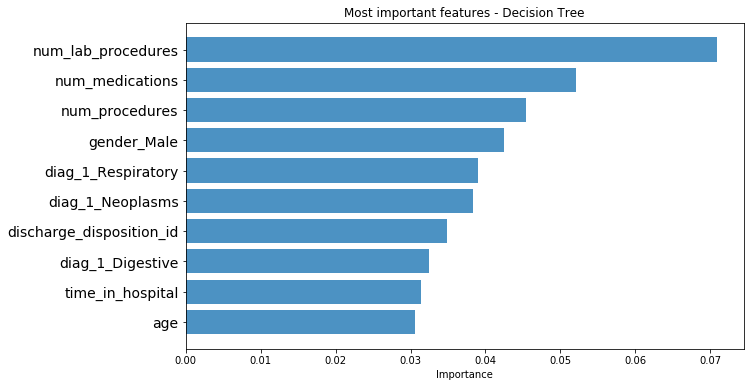

In [60]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = dtree.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree')
plt.show()

Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier
rm = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rm.fit(New_df_X, New_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [62]:
rm_prd = rm.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(rm_prd, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,18489,916,19405
1,1601,12671,14272
All,20090,13587,33677


In [63]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, rm_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test, rm_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test, rm_prd)))

accuracy_rm = accuracy_score(y_test, rm_prd)
precision_rm = precision_score(y_test, rm_prd)
recall_rm = recall_score(y_test, rm_prd)

Accuracy is 0.93
Precision is 0.93
Recall is 0.89


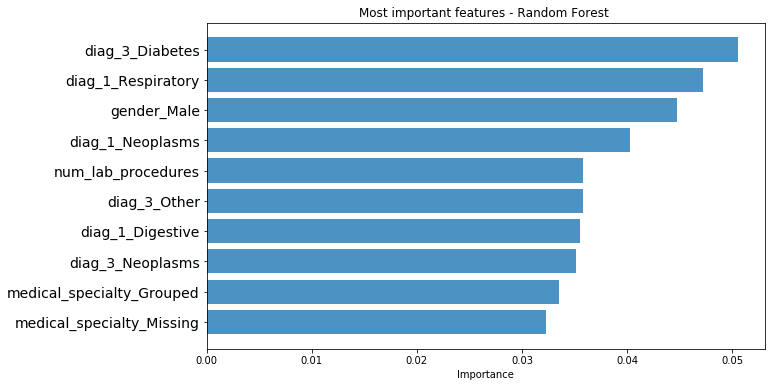

In [64]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = rm.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

Ada Boost Classifier

In [65]:
from sklearn.ensemble import AdaBoostClassifier
ad = AdaBoostClassifier()
ad.fit(New_df_X, New_y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [66]:
ad_prd = ad.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(ad_prd, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,17131,2274,19405
1,2262,12010,14272
All,19393,14284,33677


In [68]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, ad_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test, ad_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test, ad_prd)))

accuracy_ad = accuracy_score(y_test, ad_prd)
precision_ad = precision_score(y_test, ad_prd)
recall_ad = recall_score(y_test, ad_prd)

Accuracy is 0.87
Precision is 0.84
Recall is 0.84


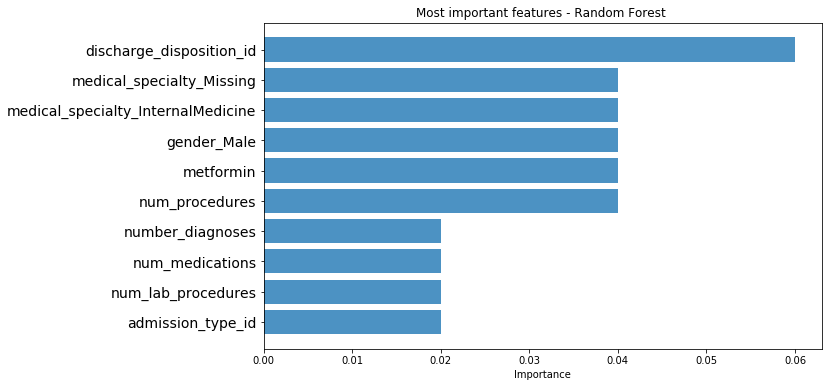

In [69]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = ad.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

Gradient Boosting Classifier

In [70]:
from sklearn.ensemble import GradientBoostingClassifier
gd = GradientBoostingClassifier()
gd.fit(New_df_X, New_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [72]:
gd_prd = gd.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(gd_prd, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,18032,1373,19405
1,2712,11560,14272
All,20744,12933,33677


In [75]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, gd_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test, gd_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test, gd_prd)))

accuracy_gd = accuracy_score(y_test, gd_prd)
precision_gd = precision_score(y_test, gd_prd)
recall_gd = recall_score(y_test, gd_prd)

Accuracy is 0.88
Precision is 0.89
Recall is 0.81


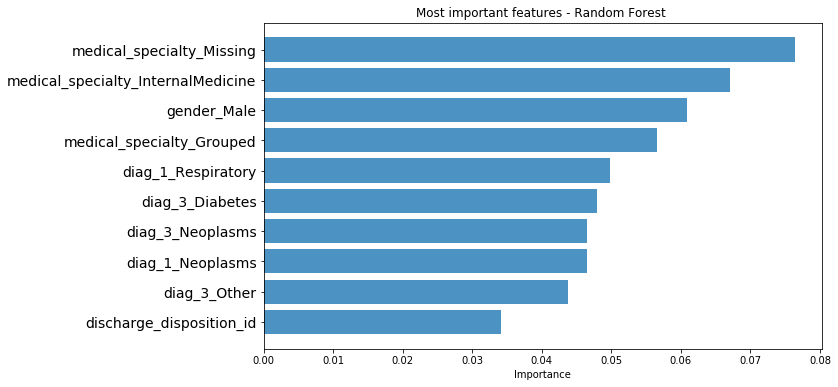

In [76]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = gd.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

Model Comparision

C:\Users\Animesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
C:\Users\Animesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


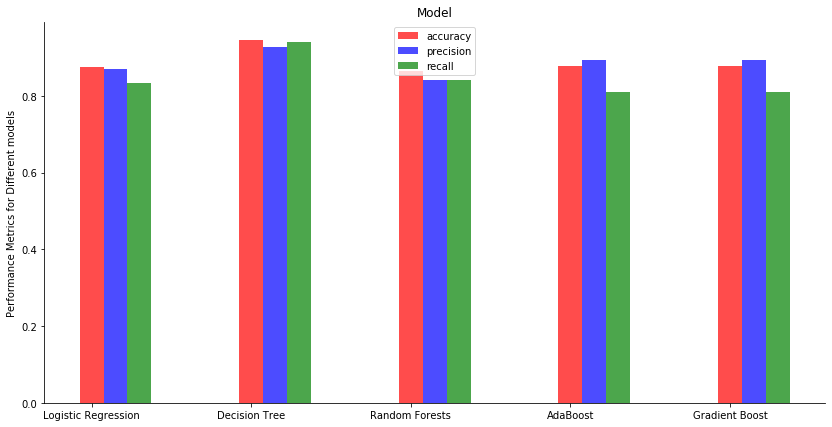

In [77]:
plt.figure(figsize=(14, 7))
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests','AdaBoost', 'Gradient Boost']
values = [accuracy_logit, accuracy_dtree, accuracy_rm,accuracy_ad, accuracy_gd]
model = np.arange(len(models))

plt.bar(model, values, align='center', width = 0.15, alpha=0.7, color = 'red', label= 'accuracy')
plt.xticks(model, models)
           

           
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests','AdaBoost', 'Gradient Boost']
values = [precision_logit, precision_dtree, precision_rm,precision_ad,precision_gd]
model = np.arange(len(models))

plt.bar(model+0.15, values, align='center', width = 0.15, alpha=0.7, color = 'blue', label = 'precision')
plt.xticks(model, models)



ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests' ,'AdaBoost', 'Gradient Boost']
values = [recall_logit, recall_dtree, recall_rm,recall_ad,recall_gd ]
model = np.arange(len(models))

plt.bar(model+0.3, values, align='center', width = 0.15, alpha=0.7, color = 'green', label = 'recall')
plt.xticks(model, models)



plt.ylabel('Performance Metrics for Different models')
plt.title('Model')
    
# removing the axis on the top and right of the plot window
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

plt.show()          

In [78]:
Models_Accuracy = pd.DataFrame([accuracy_logit, accuracy_dtree, accuracy_rm,accuracy_ad, accuracy_gd], index = models, columns = ['Accuracy'])
Models_Precision = pd.DataFrame([precision_logit, precision_dtree, precision_rm,precision_ad,precision_gd], index = models, columns = ['Precision'])
Models_Recall = pd.DataFrame([recall_logit, recall_dtree, recall_rm,recall_ad,recall_gd ], index = models, columns = ['Recall'])
Model_Comparision = pd.concat([Models_Accuracy,Models_Precision,Models_Recall] , axis = 1)
Model_Comparision

,Accuracy,Precision,Recall
Logistic Regression,0.875642,0.868729,0.832329
Decision Tree,0.944324,0.928221,0.941424
Random Forests,0.865309,0.840801,0.841508
AdaBoost,0.878701,0.893837,0.809978
Gradient Boost,0.878701,0.893837,0.809978


### Models after GridSearch CV

In [44]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [79]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

models1 = {
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    
}

params1 = {
    'RandomForestClassifier': { 'n_estimators': [16, 32] , 'max_depth': [15,30] ,  },
    'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
}

In [46]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(New_df_X, New_y, scoring='roc_', n_jobs=2)

Running GridSearchCV for ExtraTreesClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   21.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:   21.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   21.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:  1.3min finished


In [47]:
helper1.score_summary(sort_by='max_score')

ExtraTreesClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


C:\Users\Animesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,estimator,min_score,mean_score,max_score,std_score,learning_rate,max_depth,n_estimators
1,ExtraTreesClassifier,0.999132,0.999188,0.999266,5.66896e-05,NaN,NaN,32
0,ExtraTreesClassifier,0.998799,0.998821,0.998865,3.13345e-05,NaN,NaN,16
5,RandomForestClassifier,0.995078,0.995675,0.996073,0.000429671,NaN,30,32
4,RandomForestClassifier,0.989062,0.990161,0.991058,0.000827589,NaN,30,16
3,RandomForestClassifier,0.863575,0.871624,0.877387,0.00586606,NaN,15,32
2,RandomForestClassifier,0.840147,0.857024,0.867705,0.0120732,NaN,15,16
11,GradientBoostingClassifier,0.631685,0.63485,0.636943,0.00227681,1,NaN,32
9,GradientBoostingClassifier,0.61971,0.629846,0.635898,0.00721226,0.8,NaN,32
8,GradientBoostingClassifier,0.602303,0.613904,0.626968,0.0101226,0.8,NaN,16
10,GradientBoostingClassifier,0.606482,0.613792,0.617514,0.00516972,1,NaN,16
